# Transforming Process Data Stored in the Ethereum Blockchain into a IEEE Extensible Event Stream Event Log


Roman Mühlberger, Stefan Bachhofner, Claudio Di Ciccio, Luciano García-Bañuelos, and Orlenys López-Pintado

## General Information
This Jupyter notebook contains the software implementation of the approach explained in
Roman Mühlberger, Stefan Bachhofner, Claudio Di Ciccio, Luciano García-Bañuelos and Orlenys López-Pintado: Extracting Event Logs for Process Mining from Data Stored on the Blockchain.
Accepted for presentation at the Second Workshop on Security and Privacy-enhanced Business Process Management (SPBP’19), September 2nd, 2019, Vienna, Austria.
To appear in the Proc. of BPM Workshops 2019.


## General Overview
    
In this Jupyter notebook, we transform process data stored in the public Ethereum Blockchain in an Event Log formatted according to IEEE Extensible Event Stream Event (XES). The process data is from the [incident management process](#incident_management_process) used by [Weber et al](#weber_et_al). The authors report that 32 process instances with 256 transactions were run on the public Ehtereum Blockchain. We will use this information below to verify data completeness.

# Table of Contents
1. Incident Management Process

2. Automatically Extract Process Data from the Public Ethereum Blockchain via Remote Procedure Calls

3. References

# Parameter
Set ```use_pickle=True``` to load the data pertaining to the activity transactions from a serialized (pickle) file.

Set ```use_pickle=False``` to retrieve the data from an Ethereum node.

In [1]:
use_pickle = True

## Import Package

First, make sure that you have set you API Key.

In [2]:
from __future__ import absolute_import

import glob
import pickle

import pandas as pd

from extracting_event_logs_blockchain import utils

No Infura API Key found. Add environment variable INFURA_API_KEY to ensure continued API access. New keys are available at https://infura.io/signup


In [6]:
from IPython.display import display, Image

## Block Attributes
A block is a data structure, i.e. a package of data, that holds
- 0 or more transactions,
- the hash of the previous block ("parent"), and
- other data.

|FieldID | Data Type | Field Explanation |
|--------|---------|----------|
| number | number | The block number. A pending block has a value of null. |
| hash | string | The hash of the block. A pending block has a value of null. |
| parentHash | string | The hash of the parent block, i.e. the hash of the previous block in the chain. |
| nonce | string | Hash of the generated proof-of-work. A pending block has a value of null. According to the documentation, this value is meaningless. |
| sha3Uncles | string | The SHA3 of the uncles data in the block. |
| logsBloom | string | The bloom filter for the logs of the block. If it is a pending block the value is null. |
| transactionsRoot | string | The root of the transaction trier of the block |
| stateRoot | string | The root of the final state trier of the block. |
| miner | string | The address of the beneficiary to whom the mining rewards were given.
| difficulty | string | An integer that indicates the difficulty of the block. |
| totalDifficulty | string | An integer that indicates the total difficulty of the chain up this block. |
| extraData | string | The extra data field of this block. |
| size | number | The size of this block in bytes. |
| gasLimit | number | The maximum gas allowed in this block. |
| gasUsed | number | The total used gas by all transactions in this block. |
| timestamp | number | The UNIX timestamp at which the block was mined. | 
| transactions | array | The array of transactions in the block. |
| uncles | array | An array of hashes of the ommer blocks. |


## Transaction Attributes
The Transactions tab lists all transactions initiated by external accounts, regardless of who initiated them — the receiver or the sender [(External and Internal Addresses)](https://www.sitepoint.com/ethereum-internal-transactions-token-transfers/).
    
A transaction is a digitally signed message authorizing some particular action associated with the blockchain. A transaction can be for example,
- sending currency,
- sending tokens,
- registering domain names,
- making and fulfilling trade offers, or
- entering into contracts.

|FieldID | Data Type | Field Explanation |
|--------|---------|----------|
| hash | string | Hash of the transaction |
| nonce | number | The number of transactions made by the sender prior to this one. |
| blockHash | string | Hash of the block where this transaction can be found. The value is null when its block is pending. |
| blockNumber | number | Block number where this transactions can be found. The value is null when its block is pending. |
| transactionIndex | number | Integer of the transactions index position in the block. The value is null if its pending. |
| from | string | The address of the sender. |
| to | string | The address of the receiver. This field is null when its a contract creation transaction. |
| value | string | Value transferred in wei. |
| gasPrice | string | Gas price provided by the sender in wei. |
| gas | number | Gas provided by the sender. |
| input | string | The data sent along with the transaction. |
| [r](https://bitcoin.stackexchange.com/questions/38351/ecdsa-v-r-s-what-is-v) | string | Hash value. Output of the ECDSA signature. |
| [s](https://bitcoin.stackexchange.com/questions/38351/ecdsa-v-r-s-what-is-v) | string | Hash value. Output of the ECDSA signature. |
| [v](https://bitcoin.stackexchange.com/questions/38351/ecdsa-v-r-s-what-is-v) | string | The recovery ID. |


## Internal Transaction Attributes
Internal transactions, despite the name (which isn't part of the yellowpaper; it's a convention people have settled on) aren't actual transactions, and aren't included directly in the blockchain; they're value transfers that were initiated by executing a contract [(Normal transactions VS. Internal transactions in etherscan)](https://ethereum.stackexchange.com/questions/6429/normal-transactions-vs-internal-transactions-in-etherscan).


The Internal Transactions tab lists all transactions initiated by internal accounts as a result of one or more preceding transactions [(External and Internal Addresses)](https://www.sitepoint.com/ethereum-internal-transactions-token-transfers/).

Internal transactions have the same structure as transactions.

# Automatically Extract Process Data from the Public Ethereum Blockchain via RPC

## Getting the Block Numbers
We have several options for scraping the process. The first option is to iterate over all the blocks of the blockchain. While this ensures we don't miss a transaction that is associated to our process, it is not feasible for demonstration purposes because it is too time consuming. The second option is to use a block number range over which we can iterate. This would speed up the scraping process significantly. In this process, the range would be from block number 1196184 to block number 1196833. In other words, we would iterate over $ 1196833 - 1196184 = 649 $ blocks. The third option is to only retrieve blocks from which we know they contain data associated to our incident management process. In our example, this would then be 224 blocks. Here, we choose option three.

In [3]:
PATH_CSV_FILES = "./incident_management_process/*.csv"

PATHS_PROCESS_INSTANCES = sorted(glob.glob(PATH_CSV_FILES))

print(f"Total number of found files: {len(PATHS_PROCESS_INSTANCES)}")

Total number of found files: 32


In [4]:
process_instances = []

for PATH_PROCESS_INSTANCE in PATHS_PROCESS_INSTANCES:
    df = pd.read_csv(PATH_PROCESS_INSTANCE, index_col=False)
    process_instances.append(df)
    
df_process_instances = pd.concat(process_instances, axis=0)

block_numbers = list(df_process_instances.Blockno)

## Retrieving the Process
First, we create the activities dictionary.

In [5]:
activity_names = [
    "Customer has a problem", # event
    "Get problem description",
    "Ask 1st level support",
    "Explain solution",
    "Ask 2nd level support",
    "Provide feedback for account manager",
    "Ask developer",
    "Provide feedback for 1st level support",
    "Provide feedback for 2nd level support"
]

function_signatures = [
    "Customer_Has_a_Problem()",
    "Get_problem_description(int32)",
    "Ask_1st_level_support(int32)",
    "Explain_solution()",
    "Ask_2nd_level_support()",
    "Provide_feedback_for_account_manager()",
    "Ask_developer()",
    "Provide_feedback_for_1st_level_support()",
    "Provide_feedback_for_2nd_level_support()"
]

activity_resources = [
    "Key Account Manager",
    "Key Account Manager",
    "Key Account Manager",
    "Key Account Manager",
    "1st Level Support",
    "1st Level Support",
    "2nd Level Support",
    "2nd Level Support",
    "Software Developer"
]

activities_dictionary = utils.create_activities_dictionary(
    activity_names=activity_names,
    function_signatures=function_signatures,
    activity_resources=activity_resources
)

Second, we connect to a blockchain node.

In [6]:
if not use_pickle:
    # We have to get the data from the Ethereum blockchain if we don't use pickle.
    http_provider = utils.connect_to_http_provider()

Third, we retrieve the transactions that are associated to our process by using the activities dictionary we have just created.

In [7]:
activity_transactions = 0

if use_pickle:
    activity_transactions = utils.load_activity_transactions_from_pickle()
else:
    activity_transactions = utils.get_activity_transactions_from_block_numbers(
        activities_dictionary=activities_dictionary,
        block_numbers=block_numbers,
        http_provider=http_provider)

Below you find an excerpt of ```activity_transactions```. Four dots mean that information has been omitted for the sake of readability.

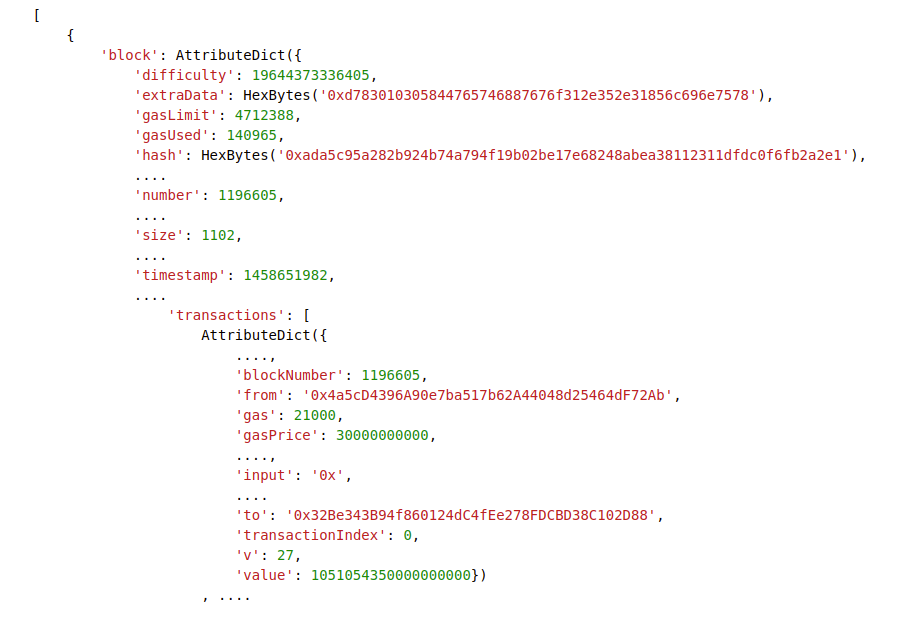

In [7]:
display(Image(filename='figures/activity_transactions_one.png'))

Fourth, we transform the transaction into a dictionary where the key is a process instance identifier and the value is the list of activity transactions (activity transactions are blockchain transactions that correspond to an activity).

In [10]:
log_dic = utils.create_log_dictionary_from_activity_transactions(
    activities_dictionary=activities_dictionary,
    activity_transactions=activity_transactions)

Below you find an excerpt of ```log_dic```. Four dots mean that information has been omitted for the sake of readability. In addition, leading or preceding 0s are also omitted for the same reason.

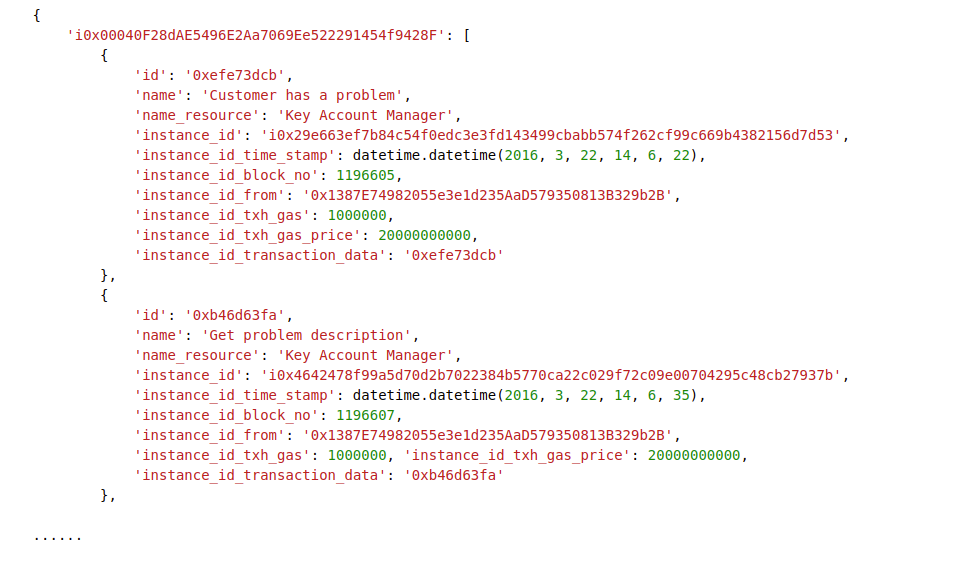

In [8]:
display(Image(filename='figures/log_dic.png'))

Fifth, we sort the activity transactions by time for convenience.

In [12]:
log_dic = utils.sort_log_dic_by_time(log_dic)

Below you find an excerpt of the sorted ```log_dic```. Four dots mean that information has been omitted for the sake of readability. In addition, leading or preceding 0s are also omitted for the same reason.

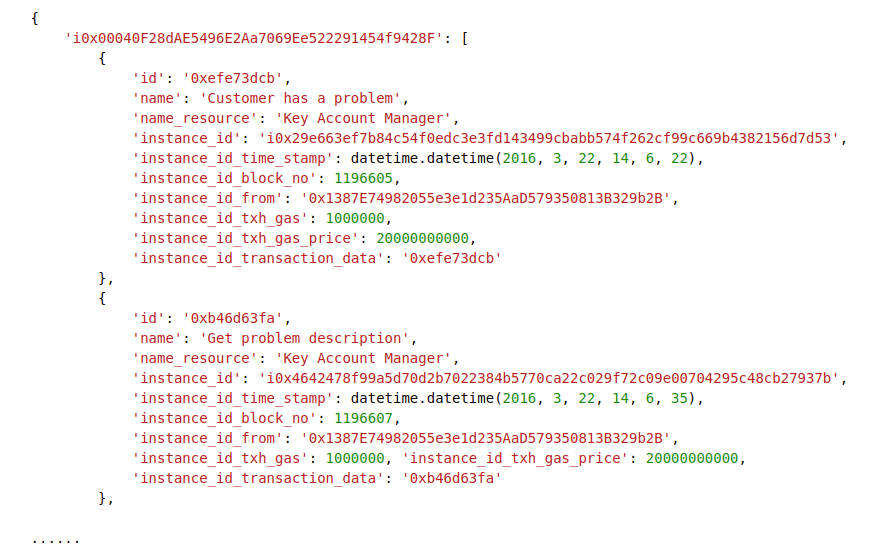

In [9]:
display(Image(filename='figures/log_dic_two.png'))

Sixth, we transform the log dictionary into a XES log object.

In [14]:
log_xes = utils.create_xes_log_from_log_dic(log_dic)

Seventh, and finally, we serialize the XES log.

In [11]:
utils.write_xes_log_to_disc(log_xes, file_name='incident_management_process')

Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (74.3818359375 msec.)



> Please make sure that you change
>
> `xes.features="nested-attributes"`
>
> to
>
> `xes.features=""`
>
> in the .xes file. Otherwise, we will get an error in ProM.

# References

Weber, I., Xu, X., Riveret, R., Governatori, G., Ponomarev, A., & Mendling, J. (2016, September). Untrusted business process monitoring and execution using blockchain. In International Conference on Business Process Management (pp. 329-347). Springer, Cham.


Di Ciccio, C., Cecconi, A., Mendling, J., Felix, D., Haas, D., Lilek, D., Riel, F., Rumpl, A. & Uhlig, P. (2018, July). Blockchain-based traceability of inter-organisational business processes. In International Symposium on Business Modeling and Software Design (pp. 56-68). Springer, Cham.


Valdivieso, H., Lee, W. L. J., Munoz-Gama, J., & Sepúlveda, M. OpyenXES: A Complete Python Library for the eXtensible Event Stream Standard.